# Twitter Sentiment Classifier | BERT
### Chatzispyrou Michail - 1115202000212

# Import essential libraries

In [1]:
import os
import random
import time
import string
import csv
import optuna

from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice


import re
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100) 

import nltk
from nltk.tokenize import word_tokenize

import spacy
!python -m spacy download el_core_news_lg --quiet
nlp = spacy.load("el_core_news_lg")

import unicodedata
from unidecode import unidecode

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
%matplotlib inline
from matplotlib.ticker import ScalarFormatter

from gensim.models import Word2Vec

from tabulate import tabulate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics import F1Score, Precision, Recall, Accuracy, ConfusionMatrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModel, logging
logging.set_verbosity_error()

✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')


# Paths
We are defening some basic paths to make our life easier when reading or writing a file

In [2]:
ROOT_PATH = "/kaggle/"
INPUT_PATH = ROOT_PATH + "input/ys19-2023-assignment-4a/"
OUTPUT_PATH = ROOT_PATH + "working/"
!mkdir MODELS

# Plotting functions
Since we were asked to plot data multiple times I preferred to make functions for each one of the plots.

In [3]:
def countplot(data, labels, percent, show, sort, title):
    if sort is not None:
        ax = sns.countplot(x=data, order=data.value_counts().sort_values(ascending=True).index)
    else:
        ax = sns.countplot(x=data)
    if percent is not None:
        for i in ax.containers:
            heights = [p.get_height() for p in i]
            for p, height in zip(i, heights):
                percentage = (height / len(data)) * 100
                ax.annotate(f"{int(height)}",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    xytext=(0, 5),
                    textcoords="offset points")
                ax.annotate(f"{percentage:.2f}%",
                    (p.get_x() + p.get_width() / 2.0, height),
                    ha="center",
                    va="center",
                    fontsize=9,
                    xytext=(0, -11),
                    textcoords="offset points")
    else:
        for i in ax.containers:
            ax.bar_label(i,)
    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:
        plt.ylabel(labels[0])
    plt.title(title)
    if show:
        plt.show()

def stackedcountplot(data, labels, x, hue, show, sort, title):
    custom_pallete = {"POSITIVE": "Green", "NEGATIVE": "red", "NEUTRAL": "gray"}
    if sort is not None:
        ax = sns.countplot(data=data, x=x, hue=hue, order=data[x].value_counts().sort_values(ascending=True).index,
                     palette=custom_pallete)
    else:
        ax = sns.countplot(data=data, x=x, hue=hue, palette=custom_pallete)
    
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',(p.get_x() + p.get_width() / 2., height),fontsize = 7,ha='center',va='bottom') 
    
    if len(labels) == 2:
        plt.xlabel(labels[0])
        plt.ylabel(labels[1])
    else:
        plt.ylabel(labels[0])
    plt.title(title)
    if show:
        plt.show()
        
def bar_chart(data, show, title, labels):
    fig, ax = plt.subplots()
    sns.barplot(x=labels, y=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_title(title)
    # Add numbers on top of the bars
    if title == "Time Taken":
        for i, val in enumerate(data):
            ax.text(i, val, val, ha='center', va='bottom', fontsize=9)
    else:
        for i, val in enumerate(data):
            ax.text(i, val, f"{val*100:.2f}%", ha='center', va='bottom', fontsize=9)
    if show:
        plt.show()

def custom_roc_curve(Y_val, y_score, show):
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    classes = [0, 1, 2]
    for i, label in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(Y_val == label, y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves for each class
    classes = ["NEGATIVE", "NEUTRAL", "POSITIVE"]
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve {classes[i]} (AUC = {roc_auc[i]*100:0.2f}%)')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    if show:
        plt.show()

def custom_learning_curve(train_score, test_score, size, xlabel, ylabel, show):
    plt.plot(size, train_score, 'o-', color="r", label="Training")
    plt.plot(size, test_score, 'o-', color="g", label="Validation")
#     plt.plot(size, train_score, color="r", label="Training")
#     plt.plot(size, test_score, color="g", label="Validation")
    
    plt.legend(loc="best")
    plt.ylabel(ylabel=ylabel)
    plt.xlabel(xlabel=xlabel)
    if show:
        plt.show()

def custom_confusion_matrix(conf_matrix, show):
    # Generate and print confusion matrix  
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["NEGATIVE", "NEUTRAL", "POSITIVE"])
    cm_display.plot(ax=plt.gca())
    plt.grid(False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    if show:
        plt.show()

# Eliminate Randomness
In order for us to achieve the same results in every execution of the notebook we are going to create a function which will initialize all the seeds with a specific number.

In [4]:
def randonmness_elimination(seed=212):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [5]:
randonmness_elimination(212)

# Loading the Dataset
We are going to load the datasets

In [6]:
# csv -> dataframe
df_train = pd.read_csv(INPUT_PATH + "train_set.csv")
df_val = pd.read_csv(INPUT_PATH + "valid_set.csv")

# Exploring the Dataset
We are going to examine the structure of the datasets in order to gain valuable insights about the data

## Firstly, we are going to check the form of the data and its content

In [7]:
# print the data frame
df_train

,New_ID,Text,Sentiment,Party
0,35027,#απολυμανση_κοριοι #απεντομωση_κοριος #απολυμανσεις #κοριος#Alphatv #Την Κυριακη #Κουλης #Τσιπρ...,NEUTRAL,SYRIZA
1,9531,Έξι νέες επιστολές για τη Μακεδονία «καίνε» τη ΝΔ - Ο Μητσοτάκης γνώριζε και δίχασε το έθνος htt...,NEGATIVE,ND
2,14146,"Ισχυρό ΚΚΕ, δύναμη του λαού στη Βουλή και στους καθημερινούς αγώνες",POSITIVE,KKE
3,28716,@five2nds @anthi7vas Μνημονιακότατο το #ΜεΡΑ25 #Εκλογες_2019 #8iouliou #epomeni_mera #ΤΩΡΑ_ΚΚΕ ...,NEUTRAL,KKE
4,32886,@ai_katerina Αυτό που είναι συγκλονιστικό είναι η ψυχασθένεια του Τσίπρα!,NEUTRAL,SYRIZA
...,...,...,...,...
36625,35374,@KourtakisJohn @kmitsotakis Ο Κούλης ο Μητσοτάκης λέει ψέματα!!!Δεν άδειασε κανένα Μπάμπη Παπαδη...,NEUTRAL,ND
36626,7744,@enikos_gr @NChatzinikolaou @AdonisGeorgiadi Πρόσεξε μην σκίσει και κανένα καλσόν. Επίσης ... χά...,NEGATIVE,ND
36627,35216,Η θέση του ΚΚΕ για την ασφάλεια των πολιτών και τους διάφορους Ρουβίκωνες είναι η βαθιά κρίση το...,NEUTRAL,KKE
36628,2855,"@thanosplevris Μαρη κακομοίρα θυγατέρα του ναζιστη αντισημίτη, έχεις ξεφτιλιστεί τόσο πολύ που ο...",NEGATIVE,ND


We can see that the train set consists of the following 4 columns:
* ID $\rightarrow$ the ID of the tweet in the dataset
* Text $\rightarrow$ the text of the tweet
* Sentiment $\rightarrow$ the sentiment label POSITIVE, NEUTRAL or NEGATIVE
* Party $\rightarrow$ the potilical party the tweet is reffering to
Finally, we can see that the number of data which will be used to train our model is 36630

## We continue the examination by visualizing the number of tweets for every political party and also the number of each sentiment label for the corresponding political party

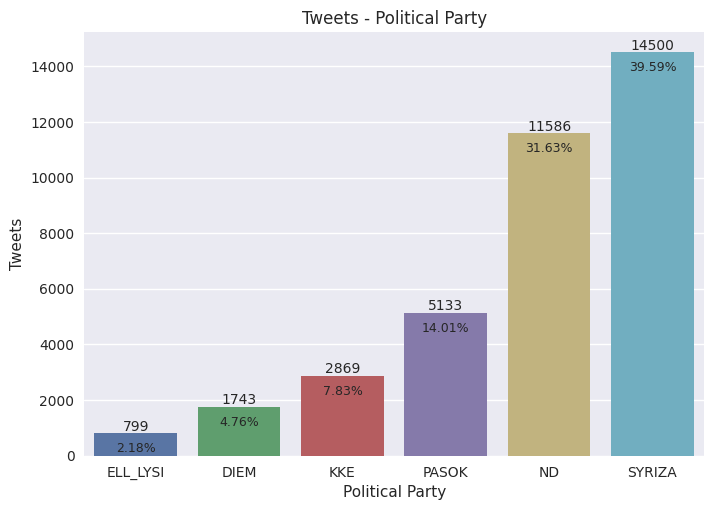

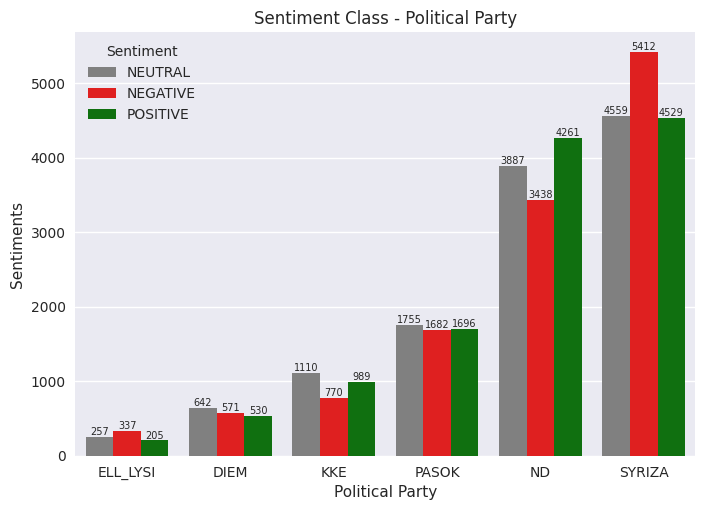

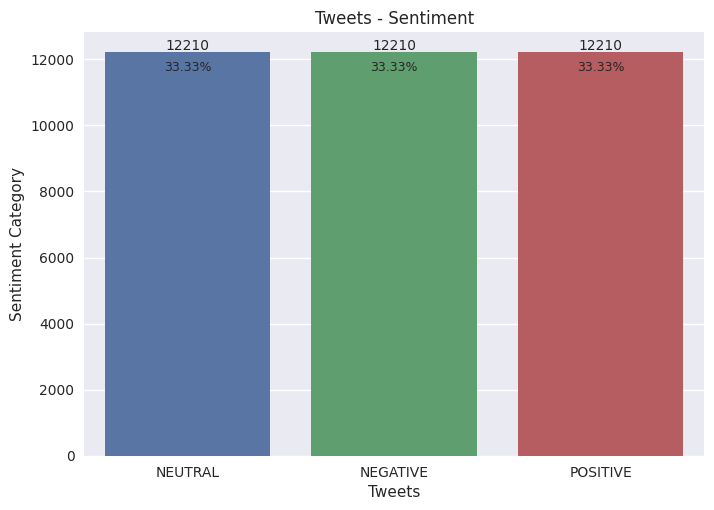

In [8]:
# Get the unique values for party
unique_values = df_train["Party"].unique()
# Find for each unique value their occurence
occurences = df_train["Party"].value_counts()[unique_values]
# Make a countplot
countplot(df_train["Party"], ["Political Party","Tweets"], True, False, True, "Tweets - Political Party")
try:
    plt.savefig('explore/tweets_pp.png')    
except:
    !mkdir explore
    plt.savefig('explore/tweets_pp.png')    
plt.show()
# Make the stacked countplot
stackedcountplot(df_train, ["Political Party","Sentiments"], "Party", "Sentiment", False, True, "Sentiment Class - Political Party")
try:
    plt.savefig('explore/sentiment_pp.png')    
except:
    !mkdir explore
    plt.savefig('explore/sentiment_pp.png')
plt.show()
# Get the unique values for sentiment
unique_values = df_train["Sentiment"].unique()
# Find for each unique value their occurence
occurences = df_train["Sentiment"].value_counts()[unique_values]
countplot(df_train["Sentiment"], ["Tweets","Sentiment Category"], True, False, None, "Tweets - Sentiment")
try:
    plt.savefig('explore/t_s.png')    
except:
    !mkdir explore
    plt.savefig('explore/t_s.png')  
plt.show()

Having thoroughly examined the dataset, we can now draw the following conclusions:
* The dataset is evenly distributed in terms of sentiment categories: </br></br>
&nbsp;&nbsp;12210 are NATURAL</br>
&nbsp;&nbsp;12210 are NEGATIVE</br>
&nbsp;&nbsp;12210 are POSITIVE</br></br>
* 39.59% of the tweets are reffering to "SYRIZA" in which:</br></br>
&nbsp;&nbsp;4559 are NATURAL</br>
&nbsp;&nbsp;5412 are NEGATIVE</br>
&nbsp;&nbsp;4529 are POSITIVE</br></br>
* 31.63% of the tweets are reffering to "ND" from which:</br></br>
&nbsp;&nbsp;3887 are NATURAL</br>
&nbsp;&nbsp;3438 are NEGATIVE</br>
&nbsp;&nbsp;4261 are POSITIVE</br></br>
* 14.01% of the tweets are reffering to "PASOK" from which:</br></br>
&nbsp;&nbsp;1755 are NATURAL</br>
&nbsp;&nbsp;1682 are NEGATIVE</br>
&nbsp;&nbsp;1696 are POSITIVE</br></br>
*  7.83% of the tweets are reffering to "KKE" from which:</br></br>
&nbsp;&nbsp;1110 are NATURAL</br>
&nbsp;&nbsp;770 are NEGATIVE</br> 
&nbsp;&nbsp;989 are POSITIVE</br></br>
*  4.76% of the tweets are reffering to "DIEM" from which:</br></br>
&nbsp;&nbsp;642 are NATURAL</br>
&nbsp;&nbsp;571 are NEGATIVE</br>
&nbsp;&nbsp;530 are POSITIVE</br></br>
*  2.18% of the tweets are reffering to "ELL_LYSI" from which:</br></br>
&nbsp;&nbsp;257 are NATURAL</br>
&nbsp;&nbsp;337 are NEGATIVE</br>
&nbsp;&nbsp;205 are POSITIVE

### We could also examine the validation set but we already know that it is the same as train set. On the other hand,  the test set does not containt the sentiment column, that's because the main purpose of this notebook is to predict their sentiment class using the train & validation sets.

# Data Pre-processing
In the previous assignment I conducted experiments with 3 different variations of the training set:
* No Pre-processing at all
* Basic Pre-processing
* Basic Pre-processing & Lemmatization<br>

## Data cleaning
The "winning" option proved to be the **Basic Pre-processing** so I'm going to do the same process below.

In [9]:
def remove_accents(word):
    ret =''.join(c for c in unicodedata.normalize('NFD', word) if unicodedata.category(c) != 'Mn')
    return ret

def clean_tweets(df):
    # That's the basic pre-processing    
    # Remove possible links starting with http/https/www
    df['Text'] = df['Text'].str.replace(r"(http[s]?://|www\.)[^\s]+", " ", regex = True)
    # Remove whole word with # symbol
    df['Text'] = df['Text'].str.replace(r"(#)[^\s]+", " ", regex = True)
    # Remove whole word with @ symbol
    df['Text'] = df['Text'].str.replace(r"(@)[^\s]+", " ", regex = True)
    # Lowercase everything
    df['Text'] = df['Text'].str.lower()
    # Keep only latin/greek letters and numbers
    df['Text'] = df['Text'].str.replace(r"[^\wa-zα-ω]", " ", regex = True)    
    # At last we are combine the tokens that are not stopwords after removing their accents to create the new text for the tweet    
    df['Text'] = df['Text'].map(lambda text: " ".join([token.text for token in nlp(remove_accents(text)) if token.text not in nlp.Defaults.stop_words and token.text.strip()]))
    # Then return the cleaned dataframe
    return df

I'm adding two more stop words in the set and also remove the accents from the stop words.

In [10]:
for word in set(nlp.Defaults.stop_words):
    nlp.Defaults.stop_words.add(remove_accents(word))
nlp.Defaults.stop_words.add('κ')
nlp.Defaults.stop_words.add('κι')

#### The cell below has to run only one time in order for the pre-process to take place. After that we can just load the cleaned dataset that was mentioned above.

In [11]:
# First wabse copy the dataframe
df_train_cleaned_bp = df_train.copy()
# Now we will clean the text column
df_train_cleaned_bp = clean_tweets(df_train_cleaned_bp)
# Save the cleaned dataset in case we need it in the future instead of cleaning it from the beginning
df_train_cleaned_bp.to_json(OUTPUT_PATH + 'cleaned_train_bp.json')
# Now we are doing the same process for the validation set
df_val_cleaned_bp = df_val.copy()
df_val_cleaned_bp = clean_tweets(df_val_cleaned_bp)
df_val_cleaned_bp.to_json(OUTPUT_PATH + 'cleaned_val_bp.json')

## Loading cleaned dataset
We are loading the cleaned dataset.

In [12]:
#Load the cleaned data for Basic Pre-Processing
df_train_bp = pd.read_json(OUTPUT_PATH + "cleaned_train_bp.json")
df_val_bp = pd.read_json(OUTPUT_PATH + "cleaned_val_bp.json")

In [13]:
df_train_bp

,New_ID,Text,Sentiment,Party
0,35027,κυριακη κοριοι απολυμανση καταπολεμηση κοριων απεντομωση κοριους,NEUTRAL,SYRIZA
1,9531,νεες επιστολες μακεδονια καινε νδ μητσοτακης γνωριζε διχασε εθνος,NEGATIVE,ND
2,14146,ισχυρο κκε δυναμη λαου βουλη καθημερινους αγωνες,POSITIVE,KKE
3,28716,μνημονιακοτατο,NEUTRAL,KKE
4,32886,συγκλονιστικο ψυχασθενεια τσιπρα,NEUTRAL,SYRIZA
...,...,...,...,...
36625,35374,κουλης μητσοτακης λεει ψεματα αδειασε μπαμπη παπαδημητριου μπαμπης προετοιμαζει ερχεται κουλη μη...,NEUTRAL,ND
36626,7744,προσεξε σκισει καλσον χαλια νεα φωτογραφια ομορφη πραγματικοτητα,NEGATIVE,ND
36627,35216,θεση κκε ασφαλεια πολιτων διαφορους ρουβικωνες βαθια κριση καπιταλιστικου συστηματος μειωση φορο...,NEUTRAL,KKE
36628,2855,μαρη κακομοιρα θυγατερα ναζιστη αντισημιτη ξεφτιλιστει τρολ νδ σχολιαζουν ντροπη μπορεις λιποθυμ...,NEGATIVE,ND


# Generic BERT Language Model
Below I will create an all in one class for both BERT models. Depending on the parameters we will give, a different language model will be created.

The `Generic BERT` consists of the following:
* Input Layer
* Hidden Size
* Output Layer
* Stacked Layers
* Dropout ratios
* Skip connections
* [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) as part of the 20% bonus


In [14]:
class GenericBERT(nn.Module):
    def __init__(self, BertName, HiddenSize, Dropout):
        super(GenericBERT, self).__init__()
        self.model = AutoModel.from_pretrained('nlpaueb/bert-base-greek-uncased-v1') if BertName == "GREEK" else AutoModel.from_pretrained('EftychiaKarav/DistilGREEK-BERT')
        self.name = BertName
        self.linear_stack = nn.Sequential( nn.Linear(self.model.config.hidden_size, HiddenSize),
                                           nn.Dropout(Dropout),
                                           nn.Linear(HiddenSize, 3))
    
    def forward(self, input_ids, attention_mask):
        out = self.model(input_ids = input_ids, attention_mask = attention_mask)
        return self.linear_stack(out[1] if self.name == "GREEK" else out[0][:, 0, :])

## Create DataLoader
Because we are building language models our data need a special represenation. The function below will convert the given dataset into a TensorDataset and then it will return the DataLoader for that dataset.

In [15]:
# This function will make a TensorDataset and then pass in a DataLoader which is returned as well
def create_dataloader(df, labels_map, bert_type, max_len, batch_size, shuffle):
    # Choose between Greek Bert and Distil Greek Bert     
    tokenizer = AutoTokenizer.from_pretrained('nlpaueb/bert-base-greek-uncased-v1' if bert_type == "GREEK" else 'EftychiaKarav/DistilGREEK-BERT')
    
    # Extract input_ids and attention_mask for the whole dataframe
    encoded = tokenizer.batch_encode_plus( df['Text'].tolist(), 
                                           add_special_tokens = True,
                                           padding = True,
                                           truncation = True,
                                           max_length = max_len, 
                                           return_tensors='pt')
    
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']
    
    # Mapping the labels based on the dictionary provided as the 2nd argument
    mapped_labels = [labels_map[label] for label in df['Sentiment']]
           
    # Convert labels to fit the requirements
    mapped_labels = torch.tensor(mapped_labels)

    # Store the TensorData
    data_set = TensorDataset(input_ids, attention_mask, mapped_labels)
    
    # Return the DataLoader
    return DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)

## Train, Test & Evaluate our model

### Show Report
The `show_report` function is responsible for displaying the results.

In [16]:
def show_report(t, loss, f, a, r, p):
    print(f"Time Taken:   \t\t{t:.3f}")
    print(f"Average Loss: \t\t{loss}")
    print(f"F1-Score:     \t\t{f}")
    print(f"Accuracy:     \t\t{a}")
    print(f"Recall:       \t\t{r}")
    print(f"Precision:    \t\t{p}")

### Testing Process
The `testing_process` makes all the nececary calculations in order to evaluate our model

In [17]:
def testing_process(model, dataloader, costFunc, device):
    preds = []
    
    targets = []
    
    model.eval()
    
    sum_losses = 0.0
    
    with torch.no_grad():
        for X, masks, y in dataloader:
            
            # Move the data to the corresponding device
            X     = X.to(device)
            masks = masks.to(device)
            y     = y.to(device)
  
            # Compute prediction and loss
            pred = model(input_ids = X, attention_mask = masks)
            loss = costFunc(pred, y)
            sum_losses += loss.item()
    
            preds.append(pred)
            targets.append(y)

    loss = sum_losses / len(dataloader)
    f = F1Score(task='multiclass', average="weighted", num_classes=3).to(device)
    a = Accuracy(task='multiclass', average="weighted", num_classes=3).to(device)
    r = Recall(task='multiclass', average="weighted", num_classes=3).to(device)
    p = Precision(task='multiclass', average="weighted", num_classes=3).to(device)
    
    f = f(torch.cat(preds), torch.cat(targets)).item()
    a = a(torch.cat(preds), torch.cat(targets)).item()
    r = r(torch.cat(preds), torch.cat(targets)).item()
    p = p(torch.cat(preds), torch.cat(targets)).item()
    
    return loss, f, a, r, p, preds, targets

### Epoch Process
The `epoch_process` function was made in order for us to train our model in each epoch

In [18]:
def epoch_process(epochs, epoch, model, dataloader, optimizer, costFunc, size, clip, device, show_progress):
    model.train()
    
    if show_progress:
        print(f"Epoch {epoch+1:{len(str(epochs))}d}\n-----------------------------")
    
    for batch, (X, masks, y) in enumerate(dataloader):
        # Move the data to the corresponding device
        X     = X.to(device)
        masks = masks.to(device)
        y     = y.to(device)

        # Compute prediction and loss
        pred = model(input_ids = X, attention_mask = masks)
        loss = costFunc(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        if clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()

        # Per 750 batches for each epoch display the loss
        if show_progress and batch % 750 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>8f}  [{current:>{len(str(size))}d}/{size:>{len(str(size))}d}]")
        
    if show_progress:
        print()

### Training Process
The `training_process` function is liable for the whole training process.

In [19]:
def training_process(epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, clip, device, show_progress):
    
    train_losses, train_f1 = [], []
    
    val_losses, val_f1 = [], []
    
    size = len(train_dataloader.dataset)
       
    for epoch in range(epochs):
    
        epoch_process(epochs, epoch, model, train_dataloader, optimizer, costFunc, size, clip, device, show_progress)

        curr_mean_train_loss, f1_train, _, _, _, _, _ = testing_process(model, train_dataloader, costFunc, device)
        train_losses.append(curr_mean_train_loss)
        train_f1.append(f1_train)
    
        curr_mean_val_loss, f1_val, _, _, _, _, _ = testing_process(model, val_dataloader, costFunc, device)
        val_losses.append(curr_mean_val_loss)
        val_f1.append(f1_val)
        
    return model, train_losses, val_losses, train_f1, val_f1

### Evaluation Process
The `evaluation_process` is the core of our notebook, it trains our model & testing our model and plot the necessary curves

In [20]:
def evaluation_process(path, train_dataloader, val_dataloader, model, epochs, optimizer, costFunc, learning_rate, clip, device, show_progress):
    model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = learning_rate)
    
    # Begin timer    
    begin_timer = time.perf_counter()
    
    # Do the train
    trained_model, train_losses, val_losses, train_f1, val_f1 = training_process(epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, clip, device, show_progress)

    # Stop timer
    stop_timer = time.perf_counter()

    # Train class report  
    loss_train, f_train, a_train, r_train, p_train, preds_train, targets_train = testing_process(trained_model, train_dataloader, costFunc, device)
    
    # Val class report  
    loss_val, f_val, a_val, r_val, p_val, preds_val, targets_val = testing_process(trained_model, val_dataloader, costFunc, device)
    
    train_class_report = classification_report( y_true = torch.cat(targets_train).cpu().numpy(), 
                                                y_pred = list(np.concatenate([(torch.max(i, 1)[1].tolist()) for i in preds_train])), 
                                                target_names=["NEGATIVE", "NEUTRAL", "POSITIVE"])
    
    val_class_report= classification_report( y_true = torch.cat(targets_val).cpu().numpy(), 
                                             y_pred = list(np.concatenate([(torch.max(i, 1)[1].tolist()) for i in preds_val])), 
                                             target_names=["NEGATIVE", "NEUTRAL", "POSITIVE"])
    
    train_class_report = list("Training classification report                  \n\n") + list(train_class_report)
    val_class_report = list("Validation classification report\n\n") + list(val_class_report)
    
    show_report(stop_timer - begin_timer, loss_val, f_val, a_val, r_val, p_val)
    
    print()
    
    for i,j in zip(''.join(train_class_report).split("\n"), ''.join(val_class_report).split("\n")):
        print(f"{i}\t\t{j}")
    
    # That's just to save the plots in order for us to download them and use them in report instead of screenshooting everything
    fig = plt.figure()
    custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], "Epochs", "Loss", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_loss.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_loss.png')  
    
    fig = plt.figure()
    custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], "Epochs", "F1-Score", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_f1.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_f1.png')      
    
    
    # Display plots       
    all_plots = [ "custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], \"Epochs\", \"Loss\", False)",
                  "custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], \"Epochs\", \"F1-Score\", False)"]
    # Make subplots
    _, axes = plt.subplots(1, len(all_plots), figsize=(15, 5))
    # Print each plot in a different subplot section
    for i, plot_command in enumerate(all_plots):
        plt.subplot(1, len(all_plots), i + 1)
        exec(f"{plot_command}")
    plt.tight_layout()
#     plt.savefig(f"{path}/combined.png")
    plt.show()

In [21]:
# Map each category to it's corresponding integer
labels_to_ints = {np.unique(df_train_bp["Sentiment"])[i]: i for i in range(0, len(np.unique(df_train_bp["Sentiment"])))}

# Algorithms and Experiments

For the experiments, I used the AdamW optimizer and the Cross-Entropy loss function as I was told to. For the development of the model, I utilized the experiment based on the following parameters:
* the size of hidden layer
* dropout probability
* number of epochs
* learning rates
* batch size
* maximum length

## Optuna Study For GreekBERT

In [22]:
# def objective_greek(trial):
#     torch.cuda.empty_cache()
    
#     HiddenSize    = trial.suggest_categorical('Hidden Size', [16, 32, 64, 128, 256])
#     Dropout       = trial.suggest_float('Dropout', 0.0, 0.5)
#     Epochs        = trial.suggest_categorical('Epochs', [2, 3, 4, 5])
#     Lr            = trial.suggest_float('Learning Rate', 1e-06, 1e-05)
#     BatchSize     = trial.suggest_categorical('Batch Size', [16, 32, 64])
#     MaxLen        = trial.suggest_categorical('Max Len', [64, 128, 256])
    
    
#     device        = "cuda" if torch.cuda.is_available() else "cpu"
#     optimizer     = torch.optim.AdamW
#     costFunc      = nn.CrossEntropyLoss() 
    
#     # Eliminate randomness    
#     randonmness_elimination(212)

#     train_dataloader = create_dataloader(df_train_bp, labels_to_ints, "GREEK", MaxLen, BatchSize, True)

#     val_dataloader = create_dataloader(df_val_bp, labels_to_ints, "GREEK", MaxLen, BatchSize, False)

#     model = GenericBERT("GREEK", HiddenSize, Dropout)
    
#     model = model.to(device)
    
#     optimizer = optimizer(model.parameters(), lr = Lr)
    
#     # Do the train
#     trained_model, _, _, _, _  = training_process(Epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, 0, device, False)
    
#     # Val class report  
#     _, f_val, _, _, _, _, _ = testing_process(trained_model, val_dataloader, costFunc, device)
    
#     return f_val

In [23]:
# # I initialized the sampler with specific seed in order to get the same results every time
# sampler = optuna.samplers.RandomSampler(seed=212)
# study_greek = optuna.create_study(direction = "maximize", sampler = sampler, study_name = "GreekBERT Study")
# study_greek.optimize(objective_greek, n_trials = 35)

In [24]:
# plot_edf(study_greek)

In [25]:
# plot_optimization_history(study_greek)

In [26]:
# plot_parallel_coordinate(study_greek)

In [27]:
# plot_param_importances(study_greek)

In [28]:
# plot_slice(study_greek)

## Optuna Study For DistilGREEK-BERT

In [29]:
# def objective_distil(trial):
#     torch.cuda.empty_cache()

#     HiddenSize    = trial.suggest_categorical('Hidden Size', [16, 32, 64, 128, 256])
#     Dropout       = trial.suggest_float('Dropout', 0.0, 0.5)
#     Epochs        = trial.suggest_categorical('Epochs', [2, 3, 4, 5])
#     Lr            = trial.suggest_float('Learning Rate', 1e-06, 1e-05)
#     BatchSize     = trial.suggest_categorical('Batch Size', [16, 32, 64])
#     MaxLen        = trial.suggest_categorical('Max Len', [64, 128, 256])
    
    
#     device        = "cuda" if torch.cuda.is_available() else "cpu"
#     optimizer     = torch.optim.AdamW
#     costFunc      = nn.CrossEntropyLoss() 
    
#     # Eliminate randomness    
#     randonmness_elimination(212)

#     train_dataloader = create_dataloader(df_train_bp, labels_to_ints, "Distil", MaxLen, BatchSize, True)

#     val_dataloader = create_dataloader(df_val_bp, labels_to_ints, "Distil", MaxLen, BatchSize, False)

#     model = GenericBERT("Distil", HiddenSize, Dropout)
    
#     model = model.to(device)
    
#     optimizer = optimizer(model.parameters(), lr = Lr)
    
#     # Do the train
#     trained_model, _, _, _, _  = training_process(Epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, 0, device, False)
    
#     # Val class report  
#     _, f_val, _, _, _, _, _ = testing_process(trained_model, val_dataloader, costFunc, device)
    
#     return f_val

In [30]:
# # I initialized the sampler with specific seed in order to get the same results every time
# sampler = optuna.samplers.RandomSampler(seed=212)
# study_distil = optuna.create_study(direction = "maximize", sampler = sampler, study_name = "DistilGREEK-BERT Study")
# study_distil.optimize(objective_distil, n_trials = 50)

In [31]:
# plot_edf(study_distil)

In [32]:
# plot_optimization_history(study_distil)

In [33]:
# plot_parallel_coordinate(study_distil)

In [34]:
# plot_param_importances(study_distil)

In [35]:
# plot_slice(study_distil)

# Best Model

### Extract all informations about the best models

In [36]:
def evaluation_process_best(path, train_dataloader, val_dataloader, model, epochs, optimizer, costFunc, learning_rate, clip, device, show_progress):
    model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr = learning_rate)
    
    # Begin timer    
    begin_timer = time.perf_counter()
    
    # Do the train
    trained_model, train_losses, val_losses, train_f1, val_f1 = training_process(epochs, optimizer, train_dataloader, val_dataloader, costFunc, model, clip, device, show_progress)

    # Stop timer
    stop_timer = time.perf_counter()
    
    loss_val, f_val, a_val, r_val, p_val, preds_val, targets_val = testing_process(trained_model, val_dataloader, costFunc, device)
       
    show_report(stop_timer - begin_timer, loss_val, f_val, a_val, r_val, p_val)
    
    print()
    
    # That's just to save the plots in order for us to download them and use them in report instead of screenshooting everything
    fig = plt.figure()
    custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], "Epochs", "Loss", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_loss.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_loss.png')  
    
    fig = plt.figure()
    custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], "Epochs", "F1-Score", False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/lr_f1.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/lr_f1.png')      
    
    # ROC Curve
    fig = plt.figure()
    custom_roc_curve(torch.cat(targets_val).cpu().numpy(), torch.cat(preds_val).cpu().numpy(), False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/roc.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/roc.png')

    # Confusion Matrix
    fig = plt.figure()
    conf_matrix = ConfusionMatrix(task='multiclass', num_classes=3, normalize='true').cpu()
    custom_confusion_matrix(conf_matrix(torch.cat(preds_val).cpu(), torch.cat(targets_val).cpu()).numpy(), False)
    plt.close(fig)
    try:
        fig.savefig(f'{path}/cm.png')    
    except:
        os.makedirs(f"{path}")
        fig.savefig(f'{path}/cm.png')
    
    
    # Display plots       
    all_plots = [ "custom_learning_curve(train_losses, val_losses, [i + 1 for i in range(epochs)], \"Epochs\", \"Loss\", False)",
                  "custom_learning_curve(train_f1, val_f1, [i + 1 for i in range(epochs)], \"Epochs\", \"F1-Score\", False)",
                  "custom_roc_curve(torch.cat(targets_val).cpu().numpy(), torch.cat(preds_val).cpu().numpy(), False)",
                  "custom_confusion_matrix(conf_matrix(torch.cat(preds_val).cpu(), torch.cat(targets_val).cpu()).numpy(), False)"
                ]
    # Make subplots
    _, axes = plt.subplots(1, len(all_plots), figsize=(20, 5))
    # Print each plot in a different subplot section
    for i, plot_command in enumerate(all_plots):
        plt.subplot(1, len(all_plots), i + 1)
        exec(f"{plot_command}")
    plt.tight_layout()
#     plt.savefig(f"{path}/combined.png")
    plt.show()

## GreekBERT

### Architecture of Best GreekBERT

In [37]:
print("The architecture of the best GreekBERT, according to optuna, is:")

print('Hidden Size:    256')
print('Dropout:        0.11216215886569281')
print('Epochs:         5')
print('Learning Rate:  3.7712893289199845e-06')
print('Batch Size:     64')
print('Max Length:     256')

The architecture of the best GreekBERT, according to optuna, is:
Hidden Size:    256
Dropout:        0.11216215886569281
Epochs:         5
Learning Rate:  3.7712893289199845e-06
Batch Size:     64
Max Length:     256


### Checking for Over/Under-fitting

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Time Taken:   		1949.149
Average Loss: 		1.0659800120970098
F1-Score:     		0.4077274799346924
Accuracy:     		0.4082568883895874
Recall:       		0.4082568883895874
Precision:    		0.4085540175437927

Training classification report                  		Validation classification report
		
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
    NEGATIVE       0.45      0.43      0.44     12210		    NEGATIVE       0.41      0.38      0.40      1744
     NEUTRAL       0.44      0.42      0.43     12210		     NEUTRAL       0.41      0.39      0.40      1744
    POSITIVE       0.44      0.50      0.47     12210		    POSITIVE       0.40      0.45      0.43      1744
		
    accuracy                           0.45     36630		    accuracy                           0.41      5232
   macro avg       0.45      0.45      0.45     36630		   macro avg       0.41      0.41      0.41      5232
weighted avg       0.45      0.45      0.45     36630

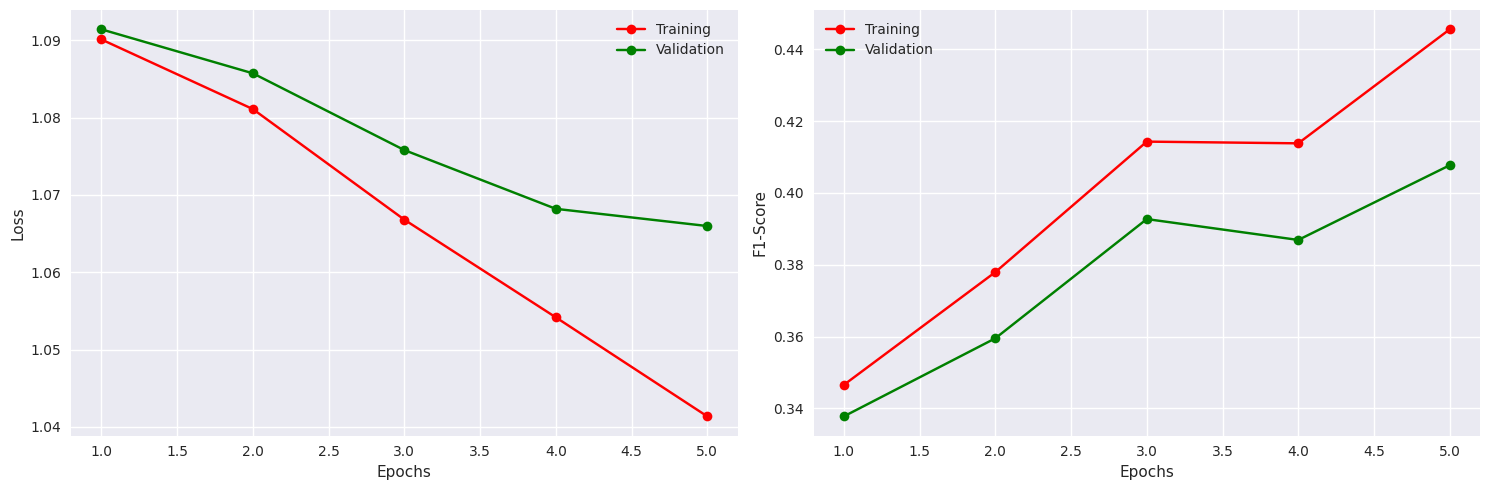

In [38]:
# Eliminate randomness    
randonmness_elimination(212)

# Create DataLoader for the train set
train_dataloader = create_dataloader(df_train_bp, labels_to_ints, "GREEK", 256, 64, True)

# Create DataLoader for the val set
val_dataloader = create_dataloader(df_val_bp, labels_to_ints, "GREEK", 256, 64, False)

model = GenericBERT("GREEK", 256, 0.11216215886569281)

evaluation_process( path = f"exp_greek",
                    train_dataloader = train_dataloader, 
                    val_dataloader = val_dataloader, 
                    model = model,
                    epochs = 5, 
                    optimizer = torch.optim.AdamW, 
                    costFunc = nn.CrossEntropyLoss(), 
                    learning_rate = 3.7712893289199845e-06,
                    clip = 0,
                    device = "cuda" if torch.cuda.is_available() else "cpu",  
                    show_progress = False)

### Extract AUC & Confusion Matrix

Time Taken:   		1948.812
Average Loss: 		1.0659800120970098
F1-Score:     		0.4077274799346924
Accuracy:     		0.4082568883895874
Recall:       		0.4082568883895874
Precision:    		0.4085540175437927



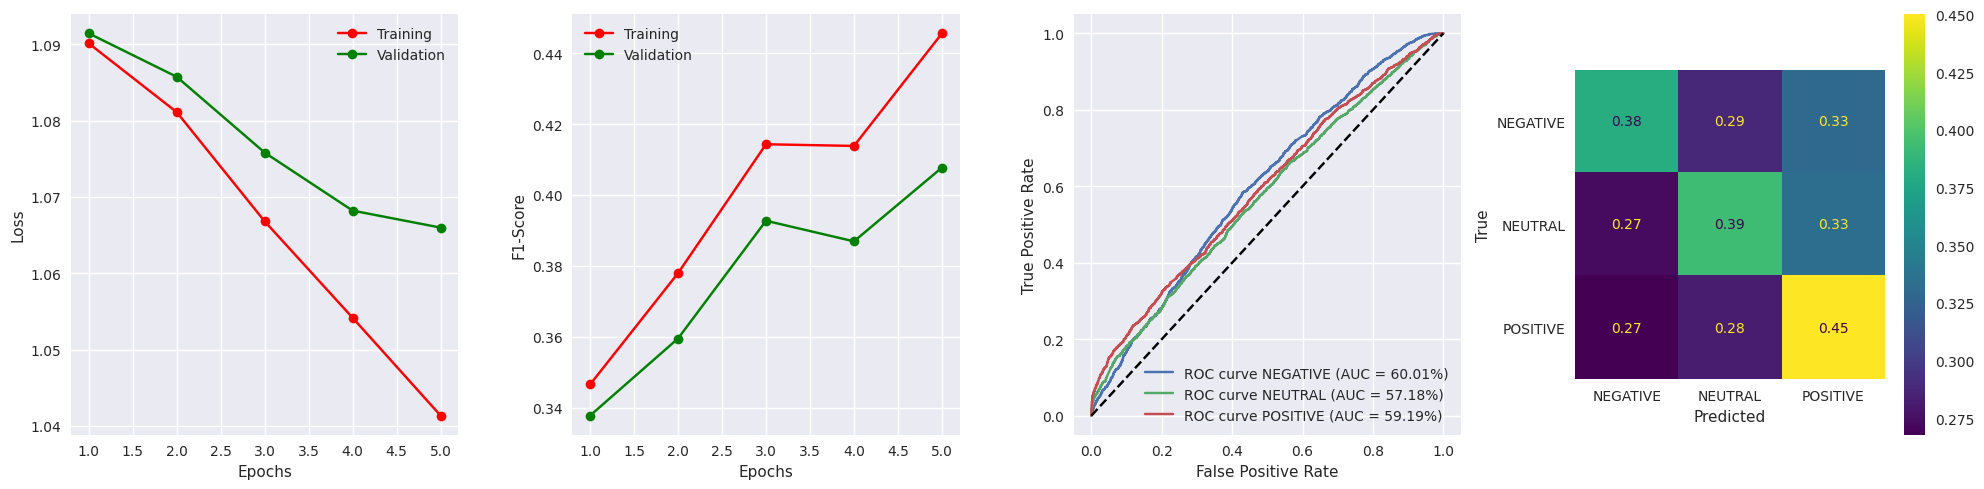

In [39]:
# Eliminate randomness    
randonmness_elimination(212)

# Create DataLoader for the train set
train_dataloader = create_dataloader(df_train_bp, labels_to_ints, "GREEK", 256, 64, True)

# Create DataLoader for the val set
val_dataloader = create_dataloader(df_val_bp, labels_to_ints, "GREEK", 256, 64, False)

model = GenericBERT("GREEK", 256, 0.11216215886569281)

evaluation_process_best( path = f"best_greek",
                         train_dataloader = train_dataloader, 
                         val_dataloader = val_dataloader, 
                         model = model,
                         epochs = 5, 
                         optimizer = torch.optim.AdamW, 
                         costFunc = nn.CrossEntropyLoss(), 
                         learning_rate = 3.7712893289199845e-06,
                         clip = 0,
                         device = "cuda" if torch.cuda.is_available() else "cpu",  
                         show_progress = False)

### Saving the Model

In [40]:
torch.save(model.state_dict(), OUTPUT_PATH + "MODELS/best_greek.pt")

## DistilGREEK-BERT

### Architecture of Best DistilGREEK-BERT

In [41]:
print("The architecture of the best DistilGREEK-BERT, according to optuna, is:")

print('Hidden Size:    16')
print('Dropout:        0.03703912923817959')
print('Epochs:         5')
print('Learning Rate:  8.971553826587668e-06')
print('Batch Size:     32')
print('Max Length:     256')

The architecture of the best DistilGREEK-BERT, according to optuna, is:
Hidden Size:    16
Dropout:        0.03703912923817959
Epochs:         5
Learning Rate:  8.971553826587668e-06
Batch Size:     32
Max Length:     256


### Checking for Over/Under-fitting

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

Time Taken:   		1065.490
Average Loss: 		1.0830115959411715
F1-Score:     		0.39259088039398193
Accuracy:     		0.3931574821472168
Recall:       		0.3931574821472168
Precision:    		0.39382022619247437

Training classification report                  		Validation classification report
		
              precision    recall  f1-score   support		              precision    recall  f1-score   support
		
    NEGATIVE       0.41      0.36      0.38     12210		    NEGATIVE       0.40      0.36      0.38      1744
     NEUTRAL       0.39      0.43      0.41     12210		     NEUTRAL       0.38      0.43      0.41      1744
    POSITIVE       0.41      0.41      0.41     12210		    POSITIVE       0.40      0.39      0.39      1744
		
    accuracy                           0.40     36630		    accuracy                           0.39      5232
   macro avg       0.40      0.40      0.40     36630		   macro avg       0.39      0.39      0.39      5232
weighted avg       0.40      0.40      0.40     366

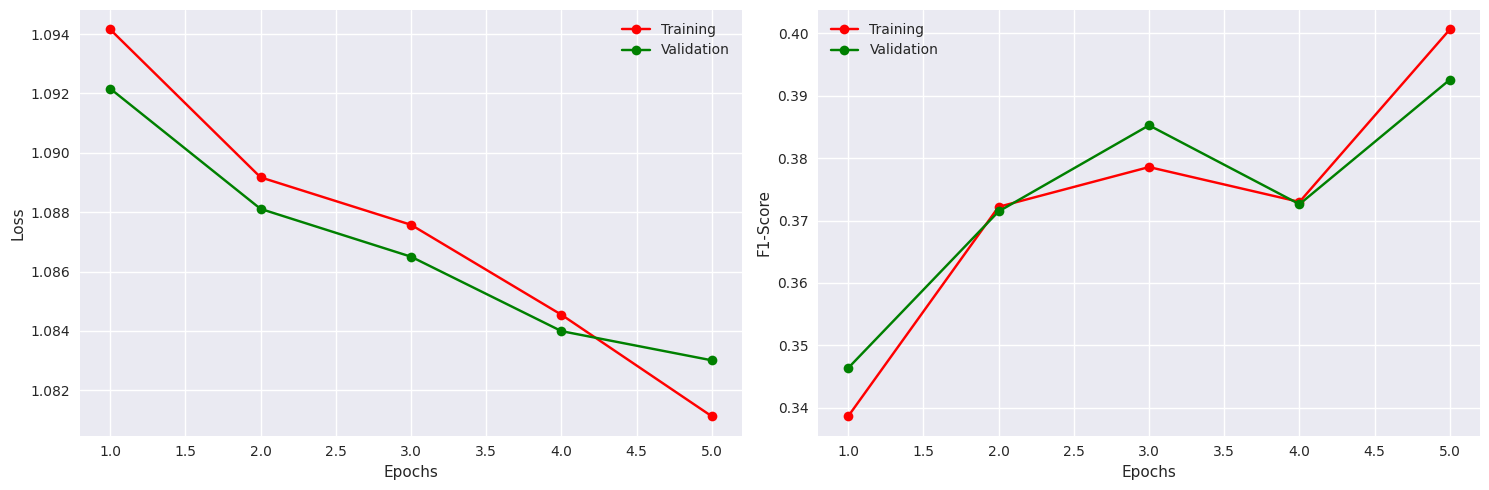

In [42]:
# Eliminate randomness    
randonmness_elimination(212)

# Create DataLoader for the train set
train_dataloader = create_dataloader(df_train_bp, labels_to_ints, "Distil", 256, 32, True)

# Create DataLoader for the val set
val_dataloader = create_dataloader(df_val_bp, labels_to_ints, "Distil", 256, 32, False)

model = GenericBERT("Distil", 16, 0.03703912923817959)

evaluation_process( path = f"exp_distil",
                    train_dataloader = train_dataloader, 
                    val_dataloader = val_dataloader, 
                    model = model,
                    epochs = 5, 
                    optimizer = torch.optim.AdamW, 
                    costFunc = nn.CrossEntropyLoss(), 
                    learning_rate = 8.971553826587668e-06,
                    clip = 0,
                    device = "cuda" if torch.cuda.is_available() else "cpu",  
                    show_progress = False)

### Extract AUC & Confusion Matrix

Time Taken:   		1065.542
Average Loss: 		1.0830115959411715
F1-Score:     		0.39259088039398193
Accuracy:     		0.3931574821472168
Recall:       		0.3931574821472168
Precision:    		0.39382022619247437



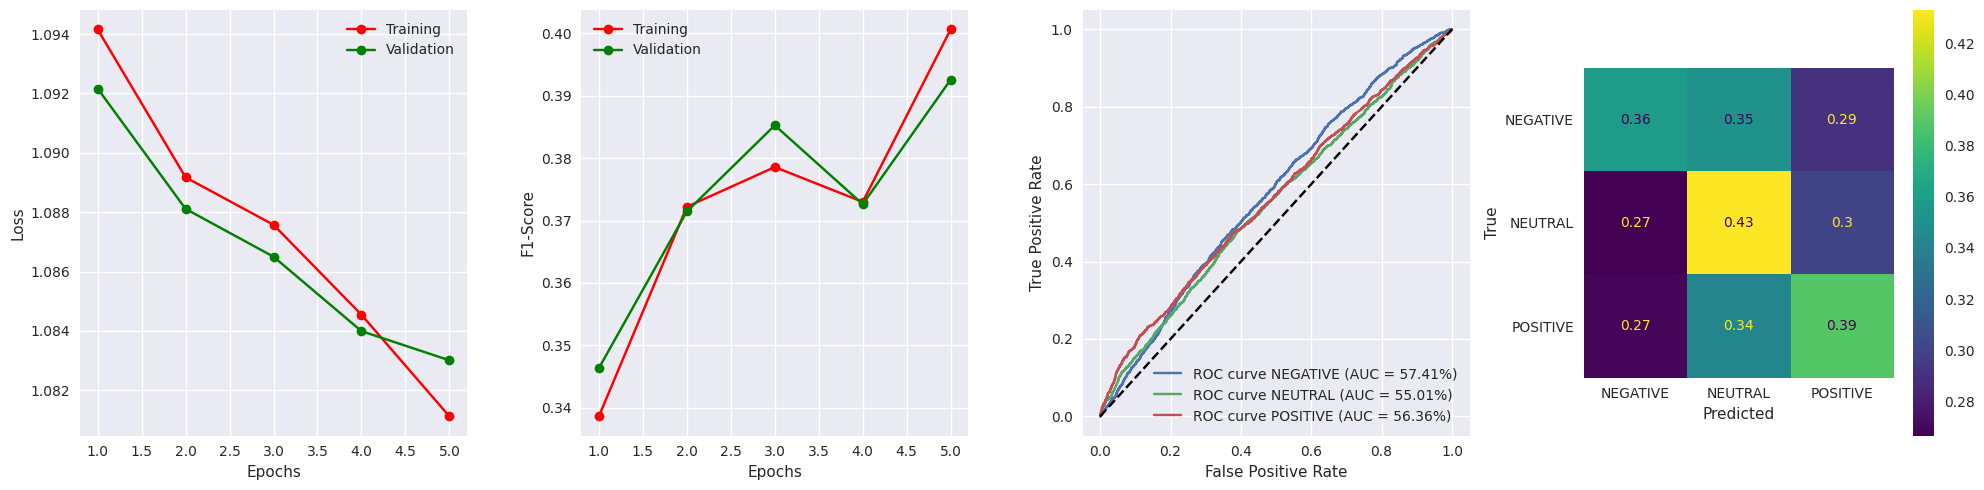

In [43]:
# Eliminate randomness    
randonmness_elimination(212)

# Create DataLoader for the train set
train_dataloader = create_dataloader(df_train_bp, labels_to_ints, "Distil", 256, 32, True)

# Create DataLoader for the val set
val_dataloader = create_dataloader(df_val_bp, labels_to_ints, "Distil", 256, 32, False)

model = GenericBERT("Distil", 16, 0.03703912923817959)

evaluation_process_best( path = f"best_distil",
                         train_dataloader = train_dataloader, 
                         val_dataloader = val_dataloader, 
                         model = model,
                         epochs = 5, 
                         optimizer = torch.optim.AdamW, 
                         costFunc = nn.CrossEntropyLoss(), 
                         learning_rate = 8.971553826587668e-06,
                         clip = 0,
                         device = "cuda" if torch.cuda.is_available() else "cpu",  
                         show_progress = False)

### Saving the Model

In [44]:
torch.save(model.state_dict(), OUTPUT_PATH + "MODELS/best_distil.pt")

In [45]:
# This cell was executed in order to take all the images with one download and categorized in their directory
!zip -r file.zip /kaggle/working/best_greek /kaggle/working/best_distil /kaggle/working/exp_distil /kaggle/working/exp_greek /kaggle/working/explore -q

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Evaluation on Test Set
The function below will make evaluations for the test set. It needs the path to the train and the test. It makes the necessary pre-processing, it creates the previous model, which was found the most optimal among many, and make predictions for the test set in the submission.csv

In [46]:
def predict_unseen_data(TEST_PATH, BERT_TYPE, CSV_NAME):
    torch.cuda.empty_cache()
    
    # Eliminate randomness    
    randonmness_elimination(212)
    df_train_cleaned_bp = pd.read_json(OUTPUT_PATH + "cleaned_train_bp.json")
        
    df_test = pd.read_csv(TEST_PATH)
       
    # First we copy the dataframe
    df_test_cleaned_bp = df_test.copy()
    
    # Now we will clean the text column
    df_test_cleaned_bp = clean_tweets(df_test_cleaned_bp)
    
    # Make dataloader for test

    # Map each category to it's corresponding integer
    labels_to_ints = {np.unique(df_train_cleaned_bp["Sentiment"])[i]: i for i in range(0, len(np.unique(df_train_cleaned_bp["Sentiment"])))}

    # And the other way around in order to change the .csv
    ints_to_labels = {i: np.unique(df_train_cleaned_bp["Sentiment"])[i] for i in range(0, len(np.unique(df_train_cleaned_bp["Sentiment"])))}
    
    device = "cuda" if torch.cuda.is_available() else "cpu"  
    
    # Choose between Greek Bert and Distil Greek Bert     
    tokenizer = AutoTokenizer.from_pretrained('nlpaueb/bert-base-greek-uncased-v1' if BERT_TYPE == "GREEK" else 'EftychiaKarav/DistilGREEK-BERT')

    # Extract input_ids and attention_mask for the whole dataframe
    encoded = tokenizer.batch_encode_plus( df_test_cleaned_bp['Text'].tolist(), 
                                           add_special_tokens = True,
                                           padding = True,
                                           truncation = True,
                                           max_length = 256,
                                           return_tensors='pt')

    # Extract input_ids for the TensorDataset
    input_ids = encoded['input_ids']
    
    # Extract attention_mask for the TensorDataset
    attention_mask = encoded['attention_mask']

    # Create and store the TensorData
    data_set = TensorDataset(input_ids, attention_mask)

    # Create and store test DataLoader
    test_dataloader =  DataLoader(dataset=data_set, batch_size= 64 if BERT_TYPE == "GREEK" else 32, shuffle=False)
    
    # Create "dummy" models in order to load the states    
    model = GenericBERT("GREEK", 256, 0.11216215886569281) if BERT_TYPE == "GREEK" else GenericBERT("Distil", 16, 0.03703912923817959)
    loaded = "best_greek.pt" if BERT_TYPE == "GREEK" else "best_distil.pt" 
    model.load_state_dict(torch.load(OUTPUT_PATH + "MODELS/" + loaded))
    
    model = model.to(device)
    
    model.eval()
    preds = []
    with torch.no_grad():
        for input_id, attention_mask in test_dataloader:
            torch.cuda.empty_cache()
            preds.append(torch.argmax(model(input_id.to(device), attention_mask.to(device)), 1))

    final = [ints_to_labels[i] for i in torch.cat(preds).tolist()]

    df_final = pd.DataFrame(list(enumerate(final, start=1)), columns=["Id", "Predicted"])
    df_final.to_csv(OUTPUT_PATH + CSV_NAME, index=False)
    
    print("\n\nSentiment Classification is done!")
    print(f"You can find the results in the {CSV_NAME}")

In [47]:
predict_unseen_data(INPUT_PATH + "test_set.csv", "GREEK", "submission.csv")



Sentiment Classification is done!
You can find the results in the submission.csv


In [48]:
predict_unseen_data(INPUT_PATH + "test_set.csv", "Distil", "submission_distil.csv")



Sentiment Classification is done!
You can find the results in the submission_distil.csv
